In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re

import tensorflow as tf

from utils import below_threshold_len

2025-02-19 14:34:21.837016: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-19 14:34:21.844837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-19 14:34:21.853927: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-19 14:34:21.856709: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-19 14:34:21.864442: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# load preprocessed amazon review dataset from directory
train_data = pd.read_csv("data/preprocessed_combined_train.csv")
print('전체 샘플수 :', (len(train_data)))

전체 샘플수 : 4828


텍스트의 최소 길이 : 9
텍스트의 최대 길이 : 239
텍스트의 평균 길이 : 53.5735294117647


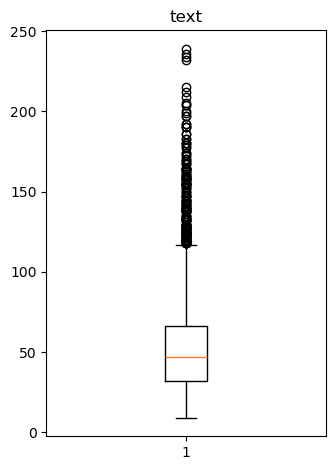

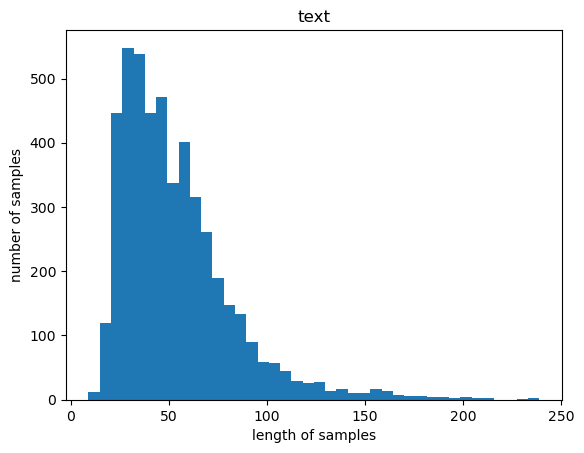

In [4]:
text_len = [len(s.split()) for s in train_data['conversation']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [5]:
# mean + 2*std를 텍스트 길이의 상한선으로 설정 -> 손실되는 text 5% 미만
text_max_len = int(np.mean(text_len) + 2 * np.std(text_len))
print(text_max_len)

111


In [6]:
below_threshold_len(text_max_len, train_data['conversation'])

전체 샘플 중 길이가 111 이하인 샘플의 비율: 0.9571251035625518


In [7]:
train_data = train_data[train_data["conversation"].apply(lambda x: len(x.split()) <= text_max_len)]

print('전체 학습 샘플수 :', (len(train_data)))

전체 학습 샘플수 : 4621


In [8]:
label_mapping = {
    '협박 대화': 0,
    '기타 괴롭힘 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '갈취 대화': 3,
    '일반 대화': 4
}

train_data['class'] = train_data['class'].map(label_mapping)

In [9]:
x_train = np.array(train_data['conversation'])
y_train = np.array(train_data['class'])

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [11]:
print('훈련 데이터의 개수 :', len(x_train))
print('훈련 레이블의 개수 :', len(x_val))
print('테스트 데이터의 개수 :', len(y_train))
print('테스트 레이블의 개수 :', len(y_val))

훈련 데이터의 개수 : 3696
훈련 레이블의 개수 : 925
테스트 데이터의 개수 : 3696
테스트 레이블의 개수 : 925


In [12]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(x_train)

In [13]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 22727
등장 빈도가 2번 이하인 희귀 단어의 수: 16114
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 6613
단어 집합에서 희귀 단어의 비율: 70.90245082940996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 10.637912883274115


In [14]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=6600)
tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(x_val)

In [15]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
x_train_tk = tokenizer.texts_to_sequences(x_train)
x_val_tk = tokenizer.texts_to_sequences(x_val)

# 잘 진행되었는지 샘플 출력
print(x_train_tk[:3])

[[18, 1, 2299, 1, 197, 335, 13, 63, 1260, 31, 551, 69, 19, 7, 1564, 19, 1435, 5, 5, 213, 20, 297, 300, 297, 300, 592, 438, 17, 11, 1, 125, 75, 14, 30, 6000, 11, 118, 508, 624, 438, 317, 2, 312, 48, 17], [15, 1565, 60, 962, 6, 2465, 6001, 2677, 167, 2465, 1566, 6, 391, 14, 1, 55, 6002, 318, 135, 686, 4147, 4886, 239, 1044, 5, 231, 15, 6003, 551, 60, 15, 146, 2, 4148, 4, 4149, 6, 204, 182, 87, 2157, 2950, 509, 25, 2157, 938, 161, 909, 6, 161, 241, 161, 36, 318, 1646, 4150, 5, 1, 574, 2, 14, 679, 204, 2951, 161], [557, 475, 1071, 116, 1, 6004, 643, 116, 3274, 364, 838, 51, 201, 475, 1567, 996, 14, 32, 116, 129, 75, 14, 1104, 281, 4151, 9, 118, 6005, 679, 4887, 6006, 100, 382, 1809, 6007, 4152, 609, 1, 88, 3275, 100, 258, 1809, 699, 101, 939, 26, 116, 12, 6008]]


In [16]:
x_train_tk = tf.keras.utils.pad_sequences(x_train_tk, maxlen=text_max_len, padding='post')
x_val_tk = tf.keras.utils.pad_sequences(x_val_tk, maxlen=text_max_len, padding='post')

#### 모델 초기화 & 학습

In [23]:
vocab_size = 6600    # 어휘 사전의 크기입니다(3~9999의 인덱스 범위)
embed_dim = 256  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# lstm model
lstm = tf.keras.Sequential()
lstm.add(tf.keras.layers.Embedding(vocab_size, embed_dim, input_shape=(None,)))
lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
lstm.add(tf.keras.layers.Dense(64, activation='relu'))
lstm.add(tf.keras.layers.Dense(5, activation='softmax'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, None, 256)      │     1,689,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,862,533 (7.10 MB)

 Trainable params: 1,862,533 (7.10 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("models/.weights.h5", 
                             monitor='val_accuracy', 
                             verbose=1,
                             save_best_only=True,
                             mode='max', 
                             save_weights_only=True)

In [25]:
lstm.compile(optimizer=tf.keras.optimizers.Adam(0.0002),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 50

history = lstm.fit(x_train_tk,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val_tk, y_val),
                    verbose=1,
                    callbacks=[checkpoint])

Epoch 1/50


5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2342 - loss: 1.6064 
Epoch 1: val_accuracy improved from -inf to 0.28541, saving model to models/.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2509 - loss: 1.6057 - val_accuracy: 0.2854 - val_loss: 1.5978
Epoch 2/50
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2965 - loss: 1.5935
Epoch 2: val_accuracy did not improve from 0.28541
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2903 - loss: 1.5923 - val_accuracy: 0.2649 - val_loss: 1.5848
Epoch 3/50
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2807 - loss: 1.5792
Epoch 3: val_accuracy improved from 0.28541 to 0.42595, saving model to models/.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2994 - loss: 1.5771 - val_accuracy: 0.4259 - val_loss: 1.5666
Epoch 4/50
5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5108 - loss: 1.5551
Epoch 4: val_accuracy improved from 0.42595 to 0.54270, saving model to models/.weights.h5
8/8 ━━━━━━━━━━━